# Viterbi

In [94]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [76]:
def gamma_viterbi_decoder(data, transition_matrix, shape_params, rate_params):
    """
    Performs Viterbi decoding for a Gamma HMM.

    Parameters:
    data (list or array): The observations.
    hidden_dim (int): Number of hidden states.
    transition_matrix (torch.Tensor): The state transition probabilities.
    shape_params (torch.Tensor): The shape parameters of the Gamma distributions.
    rate_params (torch.Tensor): The rate parameters of the Gamma distributions.

    Returns:
    list: The most likely sequence of hidden states.
    """
    hidden_dim= len(shape_params)
    states = [np.random.randint(low=0,high=hidden_dim)]
    for t in pyro.markov(range(len(data))):
        states.append(pyro.sample("states_{}".format(t),
                                  dist.Categorical(transition_matrix[states[-1]])))
        pyro.sample("obs_{}".format(t),
                    dist.Gamma(shape_params[states[-1]], rate_params[states[-1]]),
                    obs=data[t])
    return states[1:]  # returns the most likely states


Import the data:

In [115]:
data = pd.read_csv("../data/hulls_df_compact_matchday1.csv")
data = data.dropna()
sequence = torch.tensor(data["HomeHull"].values)
sequence.shape

torch.Size([3911])

Import the parametes estimated via Variational Inference:

In [75]:
posterior=torch.load("parameters/singleHMM_home.pt")
posterior

{'probs_x': tensor([[0.9631, 0.0369],
         [0.0634, 0.9366]], requires_grad=True),
 'probs_alpha': tensor([  5.5652, 120.9643], requires_grad=True),
 'probs_beta': tensor([0.0063, 0.1008], requires_grad=True)}

**Nota**: qui sotto al momento ho inserito a mano i valori...vedere se si riesce a fare in modo più automatico da *posterior*

In [109]:
transition_matrix = torch.tensor([[0.9631, 0.0369],
                                  [0.0634, 0.9366]])
shape_params = torch.tensor([5.5652, 120.9643])  
rate_params = torch.tensor([0.0063, 0.1008]) 

hidden_states = gamma_viterbi_decoder(sequence, transition_matrix=transition_matrix, shape_params=shape_params, rate_params=rate_params)

Add the most likely sequence for the Home team to our dataframe:

In [116]:
most_likely_states = np.array([int(state) for state in hidden_states])
data["HomeMLS"]=most_likely_states

In [130]:
class_colors = {
    0: 'green',
    1: 'orange'
}
colors = data['HomeMLS'].map(class_colors)

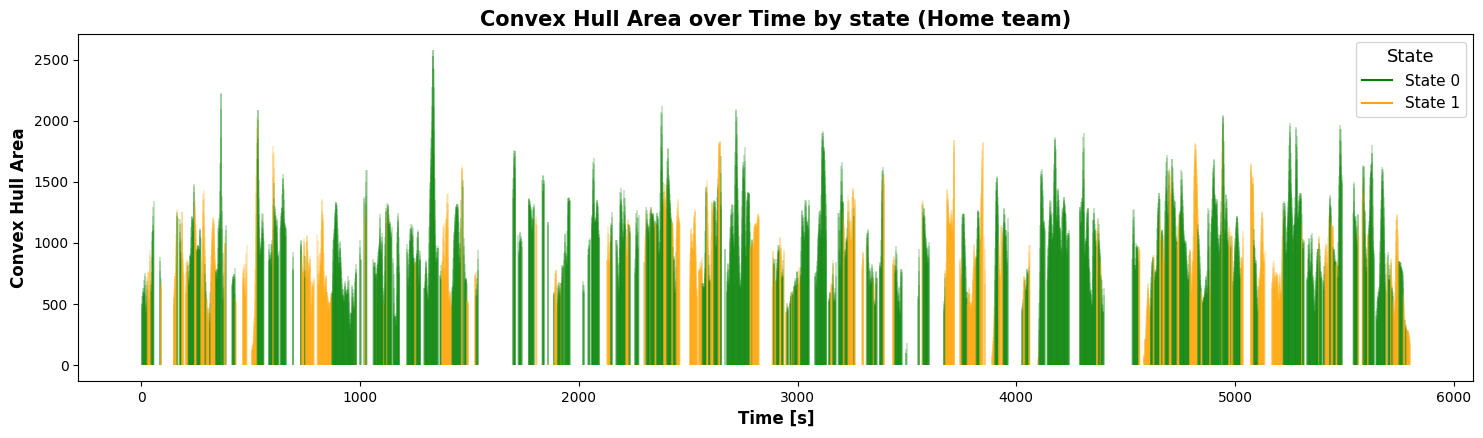

In [141]:
class_colors = {
    0: 'green',
    1: 'orange'
}
colors = data['HomeMLS'].map(class_colors)
plt.figure(figsize=(18, 4.5))
plt.vlines(data["Time [s]"], ymin=0, ymax=data["HomeHull"], color=colors,linewidth=0.3)
plt.xlabel("Time [s]", fontsize=12, fontweight='bold');
plt.ylabel("Convex Hull Area", fontsize=12, fontweight='bold');
plt.title("Convex Hull Area over Time by state (Home team)", fontsize=15, fontweight='bold');

# Creating legend manually since automatic legend does not work well with vlines
for i, state in enumerate([0,1]):
    plt.plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')

plt.legend(title="State", title_fontsize='13', fontsize='11', loc='upper right')
#plt.savefig("../plots/MostLikelySeq_HomeTeam_matchday1.png",dpi=350)